# 14 - Dados em Painel e Efeitos Fixos

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.datasets import wage_panel

%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

No capítulo anterior, exploramos uma configuração muito simples de Diff-in-Diff, onde tínhamos um grupo tratado e um grupo de controle (a cidade de POA e FLN, respectivamente) e apenas dois períodos, um pré-intervenção e um pós-intervenção. Mas o que aconteceria se tivéssemos mais períodos? Ou mais grupos? Acontece que essa configuração é tão comum e poderosa para inferência causal que recebe seu próprio nome: dados em painel. Um painel ocorre quando temos observações repetidas da mesma unidade ao longo de vários períodos de tempo. Isso acontece muito na avaliação de políticas governamentais, onde podemos acompanhar dados de várias cidades ou estados ao longo de vários anos. Mas também é incrivelmente comum na indústria, onde as empresas acompanham dados do usuário ao longo de várias semanas e meses.
 
Para compreender como podemos aproveitar essa estrutura de dados, vamos primeiro dar continuidade ao nosso exemplo de diff-in-diff, onde desejávamos estimar o impacto de instalar um outdoor (tratamento) na cidade de Porto Alegre (POA). Queremos verificar se esse tipo de estratégia de marketing offline pode impulsionar o uso de nossos produtos de investimento. Especificamente, desejamos saber o quanto os depósitos em nossa conta de investimentos aumentariam se colocássemos outdoors.
 
No capítulo anterior, motivamos o estimador DiD como uma estratégia de imputação do que teria acontecido em Porto Alegre se não tivéssemos instalado os outdoors. Dissemos que o resultado contrafactual $Y_0$ para Porto Alegre **após a intervenção** (colocar um outdoor) poderia ser inserido como o número de depósitos em Porto Alegre **antes da intervenção** mais um fator de crescimento. Este fator de crescimento foi estimado em uma cidade de controle, Florianópolis (FLN). Apenas para recapitular algumas notações, aqui está como podemos estimar esse resultado contrafactual:
 
$$
\underbrace{\widehat{Y_0(1)|D=1}}_{\substack{\text{POA outcome after intervention}} \\ \substack{\text{if no intervention had taken place}}} 
= \underbrace{Y_0(0)|D=1}_{\substack{\text{POA outcome}} \\ \substack{\text{before intervention}}} 
+ \big( \underbrace{Y_0(1)|D=0}_{\substack{\text{FLN outcome after}} \\ \substack{\text{intervention in POA}}} 
- \underbrace{Y_0(0)|D=0}_{\substack{\text{FLN outcome before}} \\ \substack{\text{intervention in POA}}} \big)
$$
 
onde $t$ denota o tempo, $D$ denota o tratamento (já que $t$ está sendo utilizado), $Y_D(t)$ denota o resultado potencial para o tratamento $D$ no período $t$ (por exemplo, $Y_0(1)$ é o resultado sob o controle no período 1). Agora, se tomarmos esse resultado potencial imputado, podemos recuperar o efeito do tratamento para POA (ATT) da seguinte forma:
 
$$
\widehat{ATT} = \underbrace{Y_1(1)|D=1}_{\substack{\text{POA outcome} \\ \text{after intervention}}} - \widehat{Y_0(1)|D=1}
$$
 
Em outras palavras, o efeito de colocar um outdoor em POA é o resultado que observamos em POA após a colocação do outdoor, subtraindo nossa estimativa do que teria acontecido se não tivéssemos colocado o outdoor. Além disso, lembre-se de que o poder do DiD advém do fato de que a estimativa do mencionado contrafactual só requer que o crescimento dos depósitos em POA corresponda ao crescimento dos depósitos em FLN. Essa é a premissa fundamental de tendências paralelas. Devemos dedicar algum tempo a isso porque ela se tornará muito importante mais adiante.
 
 
## Tendências Paralelas
 
Uma maneira de entender as premissas de tendências paralelas (ou comuns) é como uma suposição de independência. Se lembrarmos dos capítulos iniciais, a suposição de independência requer que a atribuição do tratamento seja independente dos resultados potenciais:
 
$$
Y_d \perp  D
$$
 
Isso significa que não aplicamos mais tratamento a unidades com resultados mais altos (o que causaria um viés ascendente na estimativa do efeito) ou resultados mais baixos (o que causaria um viés descendente). Em termos menos abstratos, voltando ao nosso exemplo, digamos que seu gerente de marketing decida adicionar outdoors apenas em cidades que já têm depósitos muito altos. Dessa forma, ele ou ela pode mais tarde se vangloriar de que as cidades com outdoors geram mais depósitos, então, é claro, a campanha de marketing foi um sucesso. Deixando de lado a discussão moral aqui, acredito que você possa ver que isso viola a suposição de independência: estamos aplicando o tratamento a cidades com alto $Y_0$. Além disso, lembre-se de que uma extensão natural dessa suposição é a suposição de independência condicional, que permite que os resultados potenciais dependam do tratamento a princípio, mas se tornem independentes quando condicionamos nos confundidores $X$.
 
$
Y_d \perp D | X
$
 
 
Você já conhece tudo isso. Mas como exatamente isso se relaciona com o DiD e a suposição de tendências paralelas? Se a suposição tradicional de independência afirma que a atribuição do tratamento não pode estar relacionada aos **níveis** dos resultados potenciais, a suposição de tendências paralelas afirma que a atribuição do tratamento não pode estar relacionada ao **crescimento** dos resultados potenciais ao longo do tempo. Na verdade, uma maneira de expressar a suposição de tendências paralelas é a seguinte:
 
$
\big(Y_d(t) - Y_d(t-1) \big)  \perp D
$
 
 
Em termos menos matemáticos, essa suposição está dizendo que é aceitável atribuir o tratamento a unidades que tenham um nível mais alto ou mais baixo do resultado. O que não podemos fazer é atribuir o tratamento a unidades com base em como o resultado está crescendo. No exemplo do outdoor, isso significa que está tudo bem colocar outdoors apenas em cidades com um nível inicial alto de depósitos. O que não podemos fazer é colocar outdoors apenas em cidades onde os depósitos estão crescendo mais rapidamente. Isso faz muito sentido se lembrarmos que o DiD está inserindo o crescimento contrafactual na unidade tratada com o crescimento na unidade de controle. Se o crescimento na unidade tratada sob controle for diferente do crescimento na unidade de controle, então teremos problemas.

## Controlando o que Não Pode Ser Visto

Métodos como escore de propensão, regressão linear e pareamento são muito eficazes no controle de confusão em dados não aleatórios, mas dependem de uma suposição fundamental: desconfundimento condicional.
 
$
(Y_0, Y_1) \perp T | X
$
 
Para explicar de maneira mais simples, esses métodos exigem que todos os confundidores sejam conhecidos e medidos, para que possamos condicionar sobre eles e tornar o tratamento tão equivalente ao aleatório. Um problema significativo com isso é que, às vezes, simplesmente não podemos medir um confundidor. Por exemplo, considere um problema clássico de economia do trabalho, que envolve descobrir o impacto do casamento nos ganhos dos homens. É um fato bem conhecido na economia que homens casados ganham mais do que homens solteiros. No entanto, não está claro se essa relação é causal ou não. Pode ser que homens mais educados sejam tanto mais propensos a se casar quanto mais propensos a ter um emprego com salário alto, o que significaria que a educação é um confundidor do efeito do casamento nos ganhos. Para esse confundidor, poderíamos medir a educação da pessoa no estudo e realizar uma regressão controlando isso. Mas outro confundidor poderia ser a beleza. Pode ser que homens mais bonitos sejam tanto mais propensos a se casar quanto mais propensos a ter um emprego bem remunerado. Infelizmente, a beleza é uma daquelas características, assim como a inteligência, que não conseguimos medir muito bem.
 
Isso nos coloca em uma situação difícil, porque se temos confundidores não mensurados, temos viés. Uma maneira de lidar com isso é por meio de variáveis instrumentais, como vimos anteriormente. No entanto, encontrar bons instrumentos não é tarefa fácil e requer muita criatividade. Aqui, em vez disso, vamos aproveitar a estrutura de dados em painel.
 
Já vimos como os dados em painel nos permitem substituir a suposição de desconfundimento pela suposição de tendências paralelas. Mas como exatamente isso ajuda com os confundidores não mensurados? Primeiro, vamos dar uma olhada no gráfico causal que representa essa configuração em que temos observações repetidas ao longo do tempo. Aqui, acompanhamos a mesma observação ao longo de 4 períodos de tempo. O casamento (o tratamento) e a renda (o resultado) mudam ao longo do tempo. Especificamente, o casamento é ativado (de 0 para 1) nos períodos 3 e 4, e a renda aumenta nos mesmos períodos. A beleza, o confundidor não mensurado, é o mesmo em todos os períodos (uma afirmação ousada, mas razoável se o tempo for apenas alguns anos). Então, como podemos saber que o motivo do aumento da renda é por causa do casamento e não simplesmente devido a um aumento no confundidor da beleza? E, mais importante, como podemos controlar esse confundidor que não podemos ver?
 
![img](./data/img/fixed-effects/fe-graph.png)
 
O truque é perceber que, ao ampliar uma unidade e acompanhar como ela evolui ao longo do tempo, já estamos controlando tudo o que é constante ao longo do tempo. Isso inclui quaisquer confundidores não mensurados fixos no tempo. No gráfico acima, por exemplo, já podemos saber que o aumento da renda ao longo do tempo não pode ser devido a um aumento na beleza, simplesmente porque a beleza permanece a mesma (afinal, é fixa no tempo). A conclusão é que, embora não possamos controlar a beleza, já que não podemos medi-la, ainda podemos usar a estrutura de dados em painel, tornando isso um problema resolvido.
 
Outra maneira de visualizar isso é pensar nesses confundidores fixos no tempo como atributos específicos de cada unidade. Isso seria equivalente a adicionar um nó intermediário de unidade ao nosso gráfico causal. Agora, observe como controlar a própria unidade já bloqueia o caminho não observado, mas fixo no tempo, entre o resultado e qualquer um dos confundidores.
 
![img](./data/img/fixed-effects/control-unit.png)
 
Pense nisso. Não podemos medir atributos como beleza e inteligência, mas sabemos que a pessoa que os possui é a mesma individual ao longo do tempo. A mecânica para realmente fazer esse controle é muito simples. Tudo o que precisamos fazer é criar variáveis dummy indicando essa pessoa e adicioná-las a um modelo linear. É isso que queremos dizer quando dizemos que podemos controlar a própria pessoa: estamos adicionando uma variável (dummy, neste caso) que denota aquela pessoa específica. Ao estimar o efeito do casamento na renda com essa dummy de pessoa em nosso modelo, a regressão encontra o efeito do casamento **mantendo a variável da pessoa fixa**. Adicionar essa dummy de unidade é o que chamamos de modelo de efeito fixo.

## Efeitos Fixos

Para tornar as coisas mais formais, vamos primeiro dar uma olhada nos dados que temos. Seguindo nosso exemplo, tentaremos estimar o efeito do casamento na renda. Nossos dados contêm essas 2 variáveis, `married` e `lwage`, em vários indivíduos (`nr`) por vários anos. Observe que o salário está em forma logarítmica. Além disso, temos outros controles, como o número de horas trabalhadas naquele ano, anos de educação e assim por diante.

In [2]:
data = wage_panel.load()
data.head()

,nr,year,black,...,lwage,expersq,occupation
0,13,1980,0,...,1.197540,1,9
1,13,1981,0,...,1.853060,4,9
2,13,1982,0,...,1.344462,9,9
3,13,1983,0,...,1.433213,16,9
4,13,1984,0,...,1.568125,25,5


Geralmente, o modelo de efeito fixo é definido como

$
y_{it} = \beta X_{it} + \gamma U_i + e_{it}
$

onde $y_{it}$ é o resultado do indivíduo $i$ no tempo $t$, $X_{it}$ é o vetor de variáveis para o indivíduo $i$ no tempo $t$. $U_i$ é um conjunto de variáveis não observáveis para o indivíduo $i$. Observe que essas variáveis não observáveis não mudam ao longo do tempo, daí a ausência do subscrito temporal. Finalmente, $e_{it}$ é o termo de erro. Para o exemplo da educação, $y_{it}$ são os salários em log, $X_{it}$ são as variáveis observáveis que mudam ao longo do tempo, como casamento e experiência, e $U_i$ são as variáveis que não são observadas, mas são constantes para cada indivíduo, como beleza e inteligência.


Agora, lembre-se de como eu disse que usar dados em painel com um modelo de efeito fixo é tão simples quanto adicionar uma dummy para as entidades. Isso é verdade, mas na prática, não fazemos isso de fato. Imagine um conjunto de dados com 1 milhão de clientes. Se adicionarmos uma dummy para cada um deles, acabaríamos com 1 milhão de colunas, o que provavelmente não é uma boa ideia. Em vez disso, usamos o truque de particionar a regressão linear em 2 modelos separados. Já vimos isso antes, mas agora é um bom momento para recapitular. Suponha que você tenha um modelo de regressão linear com um conjunto de características $X_1$ e outro conjunto de características $X_2$.

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

onde $X_1$ e $X_2$ são matrizes de características (uma linha por característica e uma coluna por observação) e $\hat{\beta_1}$ e $\hat{\beta_2}$ são vetores de linha. Você pode obter exatamente o mesmo parâmetro $\hat{\beta_1}$ fazendo o seguinte:

1. Regressar o resultado $y$ no segundo conjunto de características: $\hat{y^*} = \hat{\gamma_1} X_2$
2. Regressar o primeiro conjunto de características no segundo conjunto: $\hat{X_1} = \hat{\gamma_2} X_2$
3. Obter os resíduos $\tilde{X}_1 = X_1 - \hat{X_1}$ e $\tilde{y}_1 = y_1 - \hat{y^*}$
4. Regressar os resíduos do resultado nos resíduos das características: $\hat{y} = \hat{\beta_1} \tilde{X}_1$

O parâmetro dessa última regressão será exatamente o mesmo que o da regressão com todas as características. Mas como exatamente isso nos ajuda? Bem, podemos dividir a estimação do modelo com as dummies de entidades em 2. Primeiro, usamos as dummies para prever o resultado e a característica. Esses são os passos 1 e 2 acima.

Agora, lembre-se de como rodar uma regressão em uma variável dummy é tão simples quanto estimar a média para aquela dummy? Se você não lembra, vamos usar nossos dados para mostrar como isso é verdade. Vamos rodar um modelo em que prevemos salários como uma função da dummy do ano.

In [3]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


Observe como este modelo está prevendo a renda média em 1980 como 1.3935, em 1981 como 1.5129 (1.3935+0.1194) e assim por diante. Agora, se calcularmos a média por ano, obtemos o mesmo resultado exato. (Lembre-se de que o ano base, 1980, é o intercepto. Portanto, você precisa adicionar o intercepto aos parâmetros dos outros anos para obter a média de `lwage` para o ano).

In [4]:
data.groupby("year")["lwage"].mean()

year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

Isso significa que se obtermos a média para cada pessoa em nosso painel, essencialmente estamos regredindo a dummy individual nas outras variáveis. Isso motiva o seguinte procedimento de estimação:

1. Criar variáveis com ajuste temporal subtraindo a média para o indivíduo:
$\ddot{Y}_{it} = Y_{it} -  \bar{Y}_i$  
$\ddot{X}_{it} = X_{it} -  \bar{X}_i$

2. Regressar $\ddot{Y}_{it}$ on $\ddot{X}_{it}$


Observe que, ao fazer isso, o não observado $U_i$ desaparece. Como $U_i$ é constante ao longo do tempo, temos que $\bar{U_i}=U_i$. Se tivermos o seguinte sistema de duas equações:

$$
\begin{align}
Y_{it} & = \beta X_{it} + \gamma U_i + e_{it} \\
\bar{Y}_{i} & = \beta \bar{X}_{it} + \gamma \bar{U}_i + \bar{e}_{it} \\
\end{align}
$$

E subtrairmos uma da outra, obtemos:

$$
\begin{align}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + (e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{it}) \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\end{align}
$$

o que elimina todas as variáveis não observadas que são constantes ao longo do tempo. Para ser honesto, não apenas as variáveis não observadas desaparecem. Isso acontece com todas as variáveis que são constantes ao longo do tempo. Por esse motivo, você não pode incluir variáveis que são constantes ao longo do tempo, pois seriam uma combinação linear das variáveis dummy e o modelo não rodaria.

![img](./data/img/fixed-effects/demeaned.png)

Para verificar quais variáveis são essas, podemos agrupar nossos dados por indivíduo e obter a soma dos desvios padrão. Se for zero, significa que a variável não está mudando ao longo do tempo para nenhum dos indivíduos.

In [5]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

Para nossos dados, precisamos remover as dummies de etnia, `black` e `hisp`, pois são constantes para o indivíduo. Também precisamos remover a educação. Também não usaremos a ocupação, pois isso provavelmente está mediando o efeito do casamento no salário (poderia ser que homens solteiros conseguem assumir posições mais exigentes em termos de tempo). Tendo selecionado as variáveis que usaremos, é hora de estimar este modelo.

Para rodar nosso modelo de efeito fixo, primeiro, vamos obter nossos dados médios. Podemos fazer isso agrupando tudo por indivíduos e tirando a média.

In [6]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


Para ajustar os dados temporalmente, precisamos definir o índice dos dados originais como sendo o identificador individual, `nr`. Em seguida, podemos simplesmente subtrair um conjunto de dados do outro.

In [7]:
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


Finalmente, podemos rodar nosso modelo de efeito fixo nos dados com ajuste temporal.

In [8]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.679e-17,0.005,-1.32e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


Se acreditarmos que o efeito fixo elimina todo o viés da variável omitida, este modelo está nos dizendo que o casamento aumenta o salário de um homem em 11%. Este resultado é muito significativo. Um detalhe aqui é que, para modelos de efeito fixo, os erros padrão precisam ser agrupados. Então, em vez de fazer toda nossa estimativa manualmente (o que é bom apenas por razões pedagógicas), podemos usar a biblioteca `linearmodels` e definir o argumento `cluster_entity` como True.

In [9]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


Observe como as estimativas dos parâmetros são idênticas às que obtivemos com os dados com ajuste temporal. A única diferença é que os erros padrão são um pouco maiores. Agora, compare isso com o modelo OLS simples que não leva em consideração a estrutura temporal dos dados. Para este modelo, adicionamos de volta as variáveis que são constantes ao longo do tempo.

In [10]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


Este modelo está dizendo que o casamento aumenta o salário do homem em 14%. Um efeito um pouco maior do que o que encontramos com o modelo de efeito fixo. Isso sugere algum viés de variável omitida devido a fatores individuais fixos, como inteligência e beleza, que não foram adicionados ao modelo.

## Visualizando Efeitos Fixos

Para expandir nossa intuição sobre como os modelos de efeito fixo funcionam, vamos divergir um pouco para outro exemplo. Suponha que você trabalhe para uma grande empresa de tecnologia e queira estimar o impacto de uma campanha de marketing com outdoors em compras dentro do aplicativo. Ao analisar dados do passado, você percebe que o departamento de marketing tende a gastar mais para colocar outdoors em cidades onde o nível de compra é mais baixo. Isso faz sentido, não é? Eles não precisariam investir muito em publicidade se as vendas estivessem nas alturas. Se você rodar um modelo de regressão com esses dados, parece que um custo mais alto em marketing leva a menos compras dentro do aplicativo, mas apenas porque os investimentos em marketing são enviesados para regiões de baixo gasto.

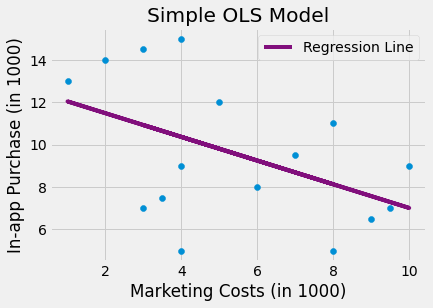

In [11]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

Sabendo muito sobre inferência causal, você decide rodar um modelo de efeito fixo, adicionando o indicador da cidade como uma variável dummy ao seu modelo. O modelo de efeito fixo controla as características específicas da cidade que são constantes ao longo do tempo, então se uma cidade é menos receptiva ao seu produto, ele capturará isso. Quando você roda esse modelo, finalmente pode ver que custos de marketing mais altos levam a mais compras dentro do aplicativo.

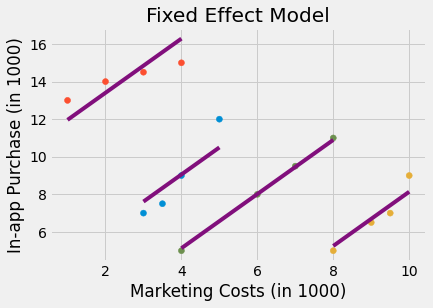

In [12]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

Dedique um minuto para apreciar o que a imagem acima está indicando sobre o que o efeito fixo está fazendo. Observe que o efeito fixo está ajustando **uma linha de regressão para cada cidade**. Também observe que as linhas são paralelas. A inclinação da linha é o efeito dos custos de marketing nas compras dentro do aplicativo. Portanto, o **efeito fixo está assumindo que o efeito causal é constante em todas as entidades**, que são as cidades neste caso. Isso pode ser uma fraqueza ou uma vantagem, dependendo de como você enxerga. É uma fraqueza se você estiver interessado em encontrar o efeito causal por cidade. Como o modelo de efeito fixo assume que esse efeito é constante entre as entidades, você não encontrará diferença no efeito causal. No entanto, se você quiser encontrar o impacto geral do marketing nas compras dentro do aplicativo, a estrutura de painel dos dados é uma alavanca muito útil que os efeitos fixos podem explorar.

## Efeitos Temporais

Assim como fizemos um efeito fixo para o nível individual, poderíamos projetar um efeito fixo para o nível temporal. Se adicionar uma dummy para cada indivíduo controla as características fixas individuais, adicionar uma dummy de tempo controlaria as variáveis que são fixas para cada período de tempo, mas que podem mudar ao longo do tempo. Um exemplo de tal variável é a inflação. Preços e salários tendem a aumentar com o tempo, mas a inflação em cada período de tempo é a mesma para todas as entidades. Para dar um exemplo mais concreto, suponha que o casamento esteja aumentando com o tempo. Se o salário e a proporção de casamentos também mudarem com o tempo, teríamos o tempo como um confundidor. Como a inflação também faz com que o salário aumente com o tempo, parte da associação positiva que vemos entre casamento e salário seria simplesmente porque ambos estão aumentando com o tempo. Para corrigir isso, podemos adicionar uma variável dummy para cada período de tempo. No `linear models`, isso é tão simples quanto adicionar `TimeEffects` à nossa fórmula e definir `cluster_time` como true.

In [13]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


Neste novo modelo, o efeito do casamento sobre o salário diminuiu significativamente de `0.1147` para `0.0476`. Ainda assim, este resultado é significativo a um nível de 99%, então os homens ainda poderiam esperar um aumento nos ganhos com o casamento.

## Quando Dados em Painel Não te Ajudarão

Usar dados em painel e modelos de efeitos fixos é uma ferramenta extremamente poderosa para inferência causal. Quando você não tem dados aleatórios nem bons instrumentos, o efeito fixo é tão convincente quanto se pode chegar para inferência causal com dados não experimentais. Ainda assim, vale a pena mencionar que isso não é uma panaceia. Existem situações em que nem mesmo dados em painel ajudarão.

O mais óbvio é quando você tem confundidores que estão mudando ao longo do tempo. Efeitos fixos só conseguem eliminar o viés de atributos que são constantes para cada indivíduo. Por exemplo, suponha que você possa aumentar seu nível de inteligência lendo livros e consumindo muitas gorduras saudáveis. Isso faz com que você consiga um emprego mais bem remunerado e uma esposa. O efeito fixo não conseguirá remover esse viés devido ao confundimento não medido pela inteligência, porque, neste exemplo, a inteligência está mudando ao longo do tempo.

![img](./data/img/fixed-effects/time-travel.png)

Outro caso menos óbvio em que o efeito fixo falha é quando há **causalidade reversa**. Por exemplo, digamos que não seja o casamento que faça você ganhar mais. É ganhar mais que aumenta suas chances de se casar. Neste caso, parecerá que eles têm uma correlação positiva, mas os ganhos vêm primeiro. Eles mudariam ao longo do tempo e na mesma direção, então os efeitos fixos não conseguiriam controlar isso.


## Conceitos-chave

Aqui, vimos como usar dados em painel, nos quais temos várias medições dos mesmos indivíduos ao longo de vários períodos de tempo. Quando esse é o caso, podemos usar um modelo de efeito fixo que controla a entidade, mantendo todos os atributos individuais constantes no tempo, fixos. Esta é uma maneira poderosa e muito convincente de controlar confundimentos e é tão boa quanto possível com dados não aleatórios.

Finalmente, vimos que o efeito fixo não é uma panaceia. Vimos duas situações em que ele não funciona: quando temos causalidade reversa e quando o confundimento não medido está mudando ao longo do tempo.

## Referências

Gosto de pensar nesta série inteira como uma homenagem a Joshua Angrist, Alberto Abadie e Christopher Walters por sua incrível aula de Econometria. A maioria das ideias aqui foram tiradas de suas aulas na *American Economic Association*. Assisti-las é o que está me mantendo são durante este difícil ano de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Também gostaria de referenciar os livros incríveis de Angrist. Eles me mostraram que Econometria, ou 'Métricas, como eles chamam, não é apenas extremamente útil, mas também profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Finalmente, gostaria de referenciar o livro de Miguel Hernan e Jamie Robins. Tem sido meu fiel companheiro nas questões mais espinhosas de inferência causal que tive que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e [abra uma issue](https://github.com/matheusfacure/python-causality-handbook/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma [estrela no GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).

---

<div align="center">
<a href="13-Difference-in-Differences.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="15-Synthetic-Control.ipynb">Próximo --></a>  
</div>